This notebook illustrates the use of convolutional networks for a multiclass classification over the MNIST dataset. This notebook is based on the PyTorch MNIST example: https://github.com/pytorch/examples/tree/master/mnist

The MNIST dataset contains handwritten digits like these:

 ![MNIST samples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each digit is 28x28 pixels and is labeled with the digit it contains, e.g. this is labeled with a "0":

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" width="200">


In [0]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

Let's define our model. The standard PyTorch way of doing so is to create a class inheriting from `torch.nn.Module`.

In its `__init__` method, we create the layers we are going to need and store them as member variables.

In its `forward` method we implement the forward pass computation, making use of the layers we created in the constructor.

### Tensor dimensions
1. Input: \[bs,28,28,1]
* Convolutional layer 1 out: \[bs,24,24,20]
* Max-pooling layer 1 out: \[bs,12,12,20]
* Convolutional layer 2 out: \[bs,8,8,50]
* Max-pooling layer 2 out: \[bs,4,4,50]
* Fully-connected layer 1 in: \[bs,4\*4\*50]
* Fully-connected layer 1 out: \[bs,500]
* Fully-connected layer 2 out: \[bs,10]
* Softmax out: \[bs,10]

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Now let's create a function that trains over an epoch. Every N steps we will `print` the progress. As input to the training, we are going to assume we receive an iterator to the training batches.

Note that, as we are facing a multiclass classification problem, we use the **negative log likelihood** (NLL) as loss function.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

And now let's create a similar function but to evaluate the performance of the model over a validation data set:

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss


Now, we will use the dataset from `torchvision` to load MNIST and the PyTorch loaders to get iterators to the batches, for both training and validation data.

This function is able to preprocess the data with different functions that are described later.

In [0]:
def train_w_preprocess(preprocesing_func):
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                     train=True,
                     download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Lambda(preprocesing_func)
                     ])),
      batch_size=train_batch_size,
      shuffle=True)

  valid_batch_size = 1000
  valid_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                     train=False,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Lambda(preprocesing_func)
                     ])),
      batch_size=valid_batch_size,
      shuffle=True)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.7)

  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(500, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      valid_loss = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)

  plt.gcf().clear()
  plt.plot(train_losses, 'b-')
  plt.plot(valid_x, valid_losses, 'r-')
  plt.ylim((0,5))
  plt.show()
  

# Preprocessing

## Feature scaling

One of the simpliest preprocessing process is feature scaling.

Original data lies in \[0,1] range.

Scaling/normalizing the data helps gradient descent converge faster.   
 <img src="https://storage.googleapis.com/aibootcamp/Week%202/assets/feature_scaling.jpg" alt="gradient descend comparison" width="500"/>
        
Typically this is done element-wise (scale each feature separetly), but in images we usually do the exact same transformation for each pixel.

## Different feature scaling methods

---

### Max-min rescaling

Escalar para que ocupe un rango deseado

*  \[-1,1]
* \[0,1]

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303351

Validation set: Average loss: 0.2425, Accuracy: 9298/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.444328

Validation set: Average loss: 0.1385, Accuracy: 9599/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.077173

Validation set: Average loss: 0.1014, Accuracy: 9699/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.110421

Validation set: Average loss: 0.0768, Accuracy: 9778/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.083244

Validation set: Average loss: 0.0683, Accuracy: 9792/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.087638

Validation set: Average loss: 0.0572, Accuracy: 9835/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.104534

Validation set: Average loss: 0.0552, Accuracy: 9831/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.076533

Validation set: Average loss: 0.0536, Accuracy: 9836/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.036431

Validation set: Average loss: 0.0437, Accuracy: 9863/10000

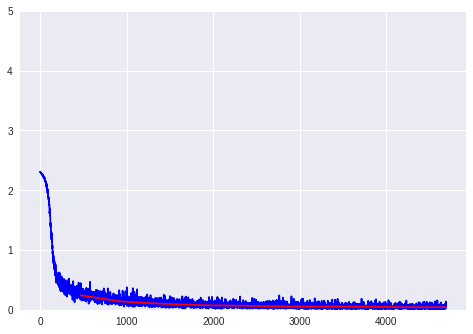

In [0]:
# [-1,1] rescaling
train_w_preprocess(lambda x : 2 * x - 1)

## Estandarizar

Resultado es un dataset de media 0 y varianza 1

$ x' = \frac{x-\hat{x}}{\sigma_x} $


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305637

Validation set: Average loss: 0.1803, Accuracy: 9467/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.134572

Validation set: Average loss: 0.1038, Accuracy: 9709/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.074033

Validation set: Average loss: 0.0835, Accuracy: 9751/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.113657

Validation set: Average loss: 0.0646, Accuracy: 9806/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.018116

Validation set: Average loss: 0.0556, Accuracy: 9838/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.048794

Validation set: Average loss: 0.0490, Accuracy: 9844/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.079669

Validation set: Average loss: 0.0444, Accuracy: 9856/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.049086

Validation set: Average loss: 0.0426, Accuracy: 9849/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.085221

Validation set: Average loss: 0.0412, Accuracy: 9866/10000

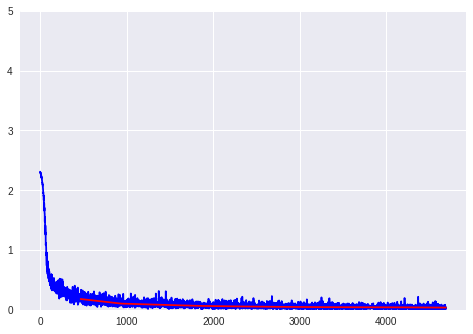

In [0]:
# standarize
mnist_mean = 0.1307
mnist_stddev = 0.3081
train_w_preprocess(lambda x : (x - mnist_mean) / mnist_stddev)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301748

Validation set: Average loss: 0.3493, Accuracy: 8978/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.340213

Validation set: Average loss: 0.1965, Accuracy: 9438/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.152086

Validation set: Average loss: 0.1429, Accuracy: 9593/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.117761

Validation set: Average loss: 0.1073, Accuracy: 9699/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.077801

Validation set: Average loss: 0.0922, Accuracy: 9730/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.142788

Validation set: Average loss: 0.0756, Accuracy: 9770/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.034759

Validation set: Average loss: 0.0657, Accuracy: 9810/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.014341

Validation set: Average loss: 0.0637, Accuracy: 9799/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.095683

Validation set: Average loss: 0.0578, Accuracy: 9826/10000

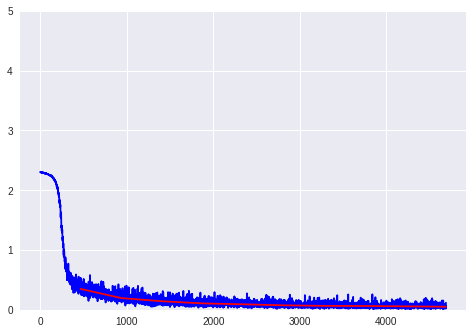

In [0]:
# no scaling (in this case it is [0,1] scaling)
train_w_preprocess(lambda x : x)

## Results

|    method   | accuracy | epochs until acc. > 98% | 
|------------------|-----------------|------------------------------|
| standarize |   98.87%  |                4               | 
|      [-1,1]      |   98.64%  |                6               | 
|      [0,1]       |   98.39%  |                7               | 